In [123]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Dataset

In [134]:
train_df = pd.read_csv('data/train.csv')

test_df = pd.read_csv('data/test.csv')


In [139]:
from sklearn.preprocessing import MinMaxScaler
def get_categorical_numerical(ddf):
    df = ddf.copy()
    g = df.columns.to_series().groupby(df.dtypes).groups
    types = {k.name: v for k, v in g.items()}
    categorical = types['object'].values
    types.pop('object')
    numerical = [val.values for key, val in types.items()]
    numerical = [elem for sublist in numerical for elem in sublist]
    return categorical, numerical

def clean_df(ddf):
    df = ddf.copy()
    df = df.dropna(axis = 1, thresh= df.shape[0] // 4)
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df = missing_value_df[missing_value_df.percent_missing > 0]
    df[missing_value_df.column_name.values].describe()
    df.MasVnrArea.fillna(method='ffill', inplace=True)
    df.MasVnrArea.fillna(method='bfill', inplace=True)
    df.LotFrontage.fillna(df.LotFrontage.median(), inplace=True)
    df.GarageYrBlt.fillna(df.GarageYrBlt.median(), inplace=True)
    round(df[missing_value_df.column_name.values].isnull().sum() / len(df), 3)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    categorical, numerical = get_categorical_numerical(df)
    numeric_features = df.loc[:,numerical[numerical != 'SalePrice']]
    numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()
    df.update(numeric_features_standardized)
    for column in categorical:
        one_hot = pd.get_dummies(df[column])
        df = df.drop(column,axis = 1)
        df = df.join(one_hot, lsuffix='_left', rsuffix='_right')
    return df

In [135]:
test_df = clean_df(test_df)
train_df = clean_df(train_df)
train_df.shape

(1460, 277)

# Training

Mean Absolute Error: 0.005435126478408534
Mean Squared Error: 0.0006301344258073763
Root Mean Squared Error: 0.025102478479372834


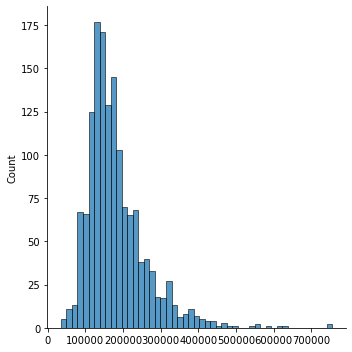

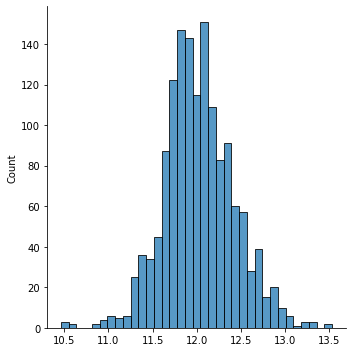

In [138]:
X = train_df.copy()
X.drop('SalePrice', axis = 1)
X.drop('Id', axis = 1)
X = X.values
y = train_df['SalePrice'].values
sns.displot(y)
y = np.log1p(y)
sns.displot(y)      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
